# Merge, Dissolve, Display

By: Steven Chao

```{admonition} Learning Objectives
* Import dataframes into Python for analysis
* Perform basic dataframe column operations
* Merge dataframes using a unique key
* Group attributes based on a similar attribute
```

## Introduction

Dataframes are widely used in Python for manipulating data. Recall that a dataframe is essentially an Excel spreadsheet (a 2-D table of rows and columns); in fact, many of the functions that you might use in Excel can often be replicated when working with dataframes in Python!

This chapter will introduce you to some of the basic operations that you can perform on dataframes. We will use these basic operations in order to calculate and map poverty rates in the Commonwealth of Virginia. We will pull data from the US Census Bureau's [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs) 2019 (see [this page](https://www.census.gov/data/developers/data-sets/acs-5year.html) for the data).

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states

## Accessing Data

### Import census data

Let's begin by accessing and importing census data. Importing census data into Python requires a Census API key. A key can be obtained from [Census API Key](http://api.census.gov/data/key_signup.html).  **It will provide you with a unique 40 digit text string. Please keep track of this number. Store it in a safe place.**

In [27]:
# Set API key
c = Census("983980b9fc504149e82117c949d7ed44653dc507")
print(c)
with open("../../../census_api.txt", "r") as f:
    b = str(f.read())
    print(type(b))
    print(b)
    print("983980b9fc504149e82117c949d7ed44653dc507")
    c = Census(b)



<class 'str'>
983980b9fc504149e82117c949d7ed44653dc507

983980b9fc504149e82117c949d7ed44653dc507


In [29]:
a = "983980b9fc504149e82117c949d7ed44653dc507"
c = Census(a)
print(type(a))


<class 'str'>


With the Census API key set, we will access the census data at the tract level for the Commonwealth of Virginia from the 2019 ACS, specifically the `ratio of income to poverty in the past 12 months` (`C17002_001E`, total; `C17002_002E`, < 0.50; and `C17002_003E`, 0.50 - 0.99) variables and the `total population` (`B01003_001E`) variable. For more information on why these variables are used, refer to the US Census Bureau's [article on how the Census Bureau measures poverty](https://www.census.gov/topics/income-poverty/poverty/guidance/poverty-measures.html) and the [list of variables found in ACS](https://api.census.gov/data/2019/acs/acs5/variables.html).

The `census` package provides us with some easy convenience methods that allow us to obtain data for a wide variety of geographies. The FIPS code for Virginia is 51, but if needed, we can also use the `us` library to help us figure out the relevant FIPS code.

In [30]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
va_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.VA.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2017)

Now that we have accessed the data and assigned it to a variable, we can read the data into a dataframe using the `pandas` library.

In [4]:
# Create a dataframe from the census data
va_df = pd.DataFrame(va_census)

# Show the dataframe
va_df

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 202, Fluvanna County, Virginia",4804.0,197.0,146.0,4863.0,51,065,020200
1,"Census Tract 4607.02, Fairfax County, Virginia",4578.0,58.0,30.0,4578.0,51,059,460702
2,"Census Tract 4612.01, Fairfax County, Virginia",4685.0,0.0,17.0,4685.0,51,059,461201
3,"Census Tract 4612.02, Fairfax County, Virginia",6403.0,258.0,45.0,6403.0,51,059,461202
4,"Census Tract 4616.01, Fairfax County, Virginia",7985.0,349.0,456.0,8001.0,51,059,461601
...,...,...,...,...,...,...,...,...
1902,"Census Tract 106, Rockingham County, Virginia",3974.0,80.0,110.0,4079.0,51,165,010600
1903,"Census Tract 101, Rockingham County, Virginia",3174.0,119.0,156.0,3195.0,51,165,010100
1904,"Census Tract 102, Rockingham County, Virginia",3548.0,117.0,205.0,3548.0,51,165,010200
1905,"Census Tract 110, Rockingham County, Virginia",3089.0,258.0,97.0,3089.0,51,165,011000


By showing the dataframe, we can see that there are 1907 rows (therefore 1907 census tracts) and 8 columns.

### Import shapefile

Let's also read into Python a shapefile of the Virginia census tracts and reproject it to the UTM Zone 17N projection. (This shapefile can be downloaded on the Census Bureau's website on the [Cartographic Boundary Files page](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html) or the [TIGER/Line Shapefiles page](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).)

In [5]:
# Access shapefile of Virginia census tracts
va_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_51_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
va_tract = va_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(va_tract)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(va_tract.crs))

     STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  \
0         51      700  032132  51700032132  321.32  Census Tract 321.32   
1         51      700  032226  51700032226  322.26  Census Tract 322.26   
2         51      087  200600  51087200600    2006    Census Tract 2006   
3         51      087  200700  51087200700    2007    Census Tract 2007   
4         51      143  011001  51143011001  110.01  Census Tract 110.01   
...      ...      ...     ...          ...     ...                  ...   
1902      51      165  010800  51165010800     108     Census Tract 108   
1903      51      165  010700  51165010700     107     Census Tract 107   
1904      51      165  010400  51165010400     104     Census Tract 104   
1905      51      165  011500  51165011500     115     Census Tract 115   
1906      51      165  011000  51165011000     110     Census Tract 110   

      MTFCC FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
0     G5020        S    25524

By printing the shapefile, we can see that the shapefile also has 1907 rows (1907 tracts). This number matches with the number of census records that we have on file. Perfect!

Not so fast, though. We have a potential problem: We have the census data, and we have the shapefile of census tracts that correspond with that data, but they are stored in two separate variables (`va_df` and `va_tract` respectively)! That makes it a bit difficult to map since these two separate datasets aren't connected to each other.

## Performing Dataframe Operations

### Create new column from old columns to get combined FIPS code

To solve this problem, we can join the two dataframes together via a field or column that is common to both dataframes, which is referred to as a key.

Looking at the two datasets above, it appears that the `GEOID` column from `va_tract` and the `state`, `county`, and `tract` columns combined from `va_df` could serve as the unique key for joining these two dataframes together. In their current forms, this join will not be successful, as we'll need to merge the `state`, `county`, and `tract` columns from `va_df` together to make it parallel to the `GEOID` column from `va_tract`. We can simply add the columns together, much like math or the basic operators in Python, and assign the "sum" to a new column.

To create a new column--or call an existing column in a dataframe--we can use indexing with `[]` and the column name (string). (There is a different way if you want to access columns using the index number; read more about indexing and selecting data [in the pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).)

In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
va_df["GEOID"] = va_df["state"] + va_df["county"] + va_df["tract"]

Printing out the first rew rows of the dataframe, we can see that the new column `GEOID` has been created with the values from the three columns combined.

In [7]:
# Print head of dataframe
print(va_df.head())

                                             NAME  C17002_001E  C17002_002E  \
0     Census Tract 202, Fluvanna County, Virginia       4804.0        197.0   
1  Census Tract 4607.02, Fairfax County, Virginia       4578.0         58.0   
2  Census Tract 4612.01, Fairfax County, Virginia       4685.0          0.0   
3  Census Tract 4612.02, Fairfax County, Virginia       6403.0        258.0   
4  Census Tract 4616.01, Fairfax County, Virginia       7985.0        349.0   

   C17002_003E  B01003_001E state county   tract        GEOID  
0        146.0       4863.0    51    065  020200  51065020200  
1         30.0       4578.0    51    059  460702  51059460702  
2         17.0       4685.0    51    059  461201  51059461201  
3         45.0       6403.0    51    059  461202  51059461202  
4        456.0       8001.0    51    059  461601  51059461601  


### Remove dataframe columns that are no longer needed

To reduce clutter, we can delete the `state`, `county`, and `tract` columns from `va_df` since we don't need them anymore. Remember that when we want to modify a dataframe, we must assign the modified dataframe back to the original variable (or a new one, if preferred). Otherwise, any modifications won't be saved. An alternative to assigning the dataframe back to the variable is to simply pass `inplace = True`. For more information, see the [pandas help documentation on `drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

In [8]:
# Remove columns
va_df = va_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
va_df

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 202, Fluvanna County, Virginia",4804.0,197.0,146.0,4863.0,51065020200
1,"Census Tract 4607.02, Fairfax County, Virginia",4578.0,58.0,30.0,4578.0,51059460702
2,"Census Tract 4612.01, Fairfax County, Virginia",4685.0,0.0,17.0,4685.0,51059461201
3,"Census Tract 4612.02, Fairfax County, Virginia",6403.0,258.0,45.0,6403.0,51059461202
4,"Census Tract 4616.01, Fairfax County, Virginia",7985.0,349.0,456.0,8001.0,51059461601
...,...,...,...,...,...,...
1902,"Census Tract 106, Rockingham County, Virginia",3974.0,80.0,110.0,4079.0,51165010600
1903,"Census Tract 101, Rockingham County, Virginia",3174.0,119.0,156.0,3195.0,51165010100
1904,"Census Tract 102, Rockingham County, Virginia",3548.0,117.0,205.0,3548.0,51165010200
1905,"Census Tract 110, Rockingham County, Virginia",3089.0,258.0,97.0,3089.0,51165011000


### Check column data types

The key in both dataframe must be of the same data type. Let's check the data type of the `GEOID` columns in both dataframes. If they aren't the same, we will have to change the data type of columns to make them the same.

In [9]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(va_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(va_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP     object
COUNTYFP    object
TRACTCE     object
GEOID       object
NAME        object
NAMELSAD    object
MTFCC       object
FUNCSTAT    object
ALAND        int64
AWATER       int64
INTPTLAT    object
INTPTLON    object
geometry    object
dtype: object


Looks like the `GEOID` columns are the same!

### Merge dataframes

Now, we are ready to merge the two dataframes together, using the `GEOID` columns as the primary key. We can use the `merge` method in `GeoPandas` called on the `va_tract` shapefile dataset.

In [10]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
va_merge = va_tract.merge(va_df, on = "GEOID")

# Show result
va_merge

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,51,700,032132,51700032132,321.32,Census Tract 321.32,G5020,S,2552457,0,+37.1475176,-076.5212499,"POLYGON ((897173.3957338206 4119897.286873336,...","Census Tract 321.32, Newport News city, Virginia",4997.0,208.0,182.0,4997.0
1,51,700,032226,51700032226,322.26,Census Tract 322.26,G5020,S,3478916,165945,+37.1625163,-076.5527816,"POLYGON ((893469.8005406747 4123469.591721422,...","Census Tract 322.26, Newport News city, Virginia",4483.0,625.0,739.0,4490.0
2,51,087,200600,51087200600,2006,Census Tract 2006,G5020,S,2440454,3537,+37.6118939,-077.4784858,"POLYGON ((809921.9093379765 4169256.112818544,...","Census Tract 2006, Henrico County, Virginia",4716.0,213.0,112.0,4731.0
3,51,087,200700,51087200700,2007,Census Tract 2007,G5020,S,3004440,61338,+37.6106740,-077.4605089,"POLYGON ((811247.6137444822 4169137.13814925, ...","Census Tract 2007, Henrico County, Virginia",3533.0,510.0,332.0,3697.0
4,51,143,011001,51143011001,110.01,Census Tract 110.01,G5020,S,127726451,167026,+36.6590883,-079.5925411,"POLYGON ((617144.0527351421 4056835.930570341,...","Census Tract 110.01, Pittsylvania County, Virg...",4041.0,155.0,275.0,4048.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,51,165,010800,51165010800,108,Census Tract 108,G5020,S,60388605,323261,+38.6073797,-078.7538433,"POLYGON ((689152.8719566716 4272544.227491042,...","Census Tract 108, Rockingham County, Virginia",6667.0,437.0,304.0,6676.0
1903,51,165,010700,51165010700,107,Census Tract 107,G5020,S,81990252,257288,+38.5880235,-078.8719806,"POLYGON ((678587.4366177632 4270263.001431893,...","Census Tract 107, Rockingham County, Virginia",3890.0,106.0,167.0,3901.0
1904,51,165,010400,51165010400,104,Census Tract 104,G5020,S,110603677,434809,+38.5503609,-078.7168103,"POLYGON ((691379.4282148019 4267271.609853343,...","Census Tract 104, Rockingham County, Virginia",2168.0,85.0,178.0,2168.0
1905,51,165,011500,51165011500,115,Census Tract 115,G5020,S,10292725,225318,+38.3884912,-078.9644518,"POLYGON ((675524.2737971413 4250519.229050484,...","Census Tract 115, Rockingham County, Virginia",4675.0,115.0,160.0,6127.0


Success! We still have 1907 rows, which means that all rows (or most of them) were successfully matched! Notice how the census data has been added on after the shapefile data in the dataframe.

Some additional notes about joining dataframes:
* the columns for the key do not need to have the same name.
* for this join, we had a one-to-one relationship, meaning one attribute in one dataframe matched to one (and only one) attribute in the other dataframe. Joins with a many-to-one, one-to-many, or many-to-many relationship are also possible, but in some cases, they require some special considerations. See this [Esri ArcGIS help documentation on joins and relates](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/tables/about-joining-and-relating-tables.htm) for more information.

### Subset dataframe

Now that we merged the dataframes together, we can further clean up the dataframe and remove columns that are not needed. Instead of using the `drop` method, we can simply select the columns we want to keep and create a new dataframe with those selected columns.

In [11]:
# Create new dataframe from select columns
va_poverty_tract = va_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
va_poverty_tract

,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,51,700,032132,51700032132,"POLYGON ((897173.3957338206 4119897.286873336,...",4997.0,208.0,182.0,4997.0
1,51,700,032226,51700032226,"POLYGON ((893469.8005406747 4123469.591721422,...",4483.0,625.0,739.0,4490.0
2,51,087,200600,51087200600,"POLYGON ((809921.9093379765 4169256.112818544,...",4716.0,213.0,112.0,4731.0
3,51,087,200700,51087200700,"POLYGON ((811247.6137444822 4169137.13814925, ...",3533.0,510.0,332.0,3697.0
4,51,143,011001,51143011001,"POLYGON ((617144.0527351421 4056835.930570341,...",4041.0,155.0,275.0,4048.0
...,...,...,...,...,...,...,...,...,...
1902,51,165,010800,51165010800,"POLYGON ((689152.8719566716 4272544.227491042,...",6667.0,437.0,304.0,6676.0
1903,51,165,010700,51165010700,"POLYGON ((678587.4366177632 4270263.001431893,...",3890.0,106.0,167.0,3901.0
1904,51,165,010400,51165010400,"POLYGON ((691379.4282148019 4267271.609853343,...",2168.0,85.0,178.0,2168.0
1905,51,165,011500,51165011500,"POLYGON ((675524.2737971413 4250519.229050484,...",4675.0,115.0,160.0,6127.0


Notice how the number of columns dropped from 13 to 9.

### Dissolve geometries and get summarized statistics to get poverty statistics at the county level

Next, we will group all the census tracts within the same county (`COUNTYFP`) and aggregate the poverty and population values for those tracts within the same county. We can use the `dissolve` function in `GeoPandas`, which is the spatial version of `groupby` in `pandas`. We use `dissolve` instead of `groupby` because the former also groups and merges all the geometries (in this case, census tracts) within a given group (in this case, counties).

In [12]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
va_poverty_county = va_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
va_poverty_county

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E
COUNTYFP,,,,,
001,"POLYGON ((971900.6993040938 4160101.039280426,...",32325.0,2352.0,3789.0,32673.0
003,"POLYGON ((734957.169547762 4207640.281805493, ...",100293.0,5034.0,4108.0,107405.0
005,"POLYGON ((597839.3087435279 4194522.270767287,...",14830.0,1700.0,1225.0,15157.0
007,"POLYGON ((778844.2912958101 4138890.927423591,...",12861.0,526.0,849.0,12953.0
009,"POLYGON ((669198.9978336127 4140588.796737842,...",30994.0,2137.0,2190.0,31775.0
...,...,...,...,...,...
800,"POLYGON ((864224.4453322524 4053745.828034676,...",89418.0,4632.0,4635.0,90093.0
810,"POLYGON ((936490.2442467227 4059315.224522595,...",439531.0,15949.0,16234.0,450201.0
820,"POLYGON ((679916.937302555 4214126.826675802, ...",21830.0,1612.0,2047.0,22140.0


Notice that we got the number of rows down from 1907 to 133.

### Perform column math to get poverty rates

We can estimate the poverty rate by dividing the sum of `C17002_002E` (ratio of income to poverty in the past 12 months, < 0.50) and `C17002_003E` (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by `B01003_001E` (total population).

Side note: Notice that `C17002_001E` (ratio of income to poverty in the past 12 months, total), which theoretically should count everyone, does not exactly match up with `B01003_001E` (total population). We'll disregard this for now since the difference is not too significant.

In [13]:
# Get poverty rate and store values in new column
va_poverty_county["Poverty_Rate"] = (va_poverty_county["C17002_002E"] + va_poverty_county["C17002_003E"]) / va_poverty_county["B01003_001E"] * 100

# Show dataframe
va_poverty_county

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((971900.6993040938 4160101.039280426,...",32325.0,2352.0,3789.0,32673.0,18.795336
003,"POLYGON ((734957.169547762 4207640.281805493, ...",100293.0,5034.0,4108.0,107405.0,8.511708
005,"POLYGON ((597839.3087435279 4194522.270767287,...",14830.0,1700.0,1225.0,15157.0,19.298014
007,"POLYGON ((778844.2912958101 4138890.927423591,...",12861.0,526.0,849.0,12953.0,10.615301
009,"POLYGON ((669198.9978336127 4140588.796737842,...",30994.0,2137.0,2190.0,31775.0,13.617624
...,...,...,...,...,...,...
800,"POLYGON ((864224.4453322524 4053745.828034676,...",89418.0,4632.0,4635.0,90093.0,10.286038
810,"POLYGON ((936490.2442467227 4059315.224522595,...",439531.0,15949.0,16234.0,450201.0,7.148585
820,"POLYGON ((679916.937302555 4214126.826675802, ...",21830.0,1612.0,2047.0,22140.0,16.526649


## Plotting Results

Finally, since we have the spatial component connected to our census data, we can plot the results!

Text(0.5, 1, 'Poverty Rates (%) in Virginia')

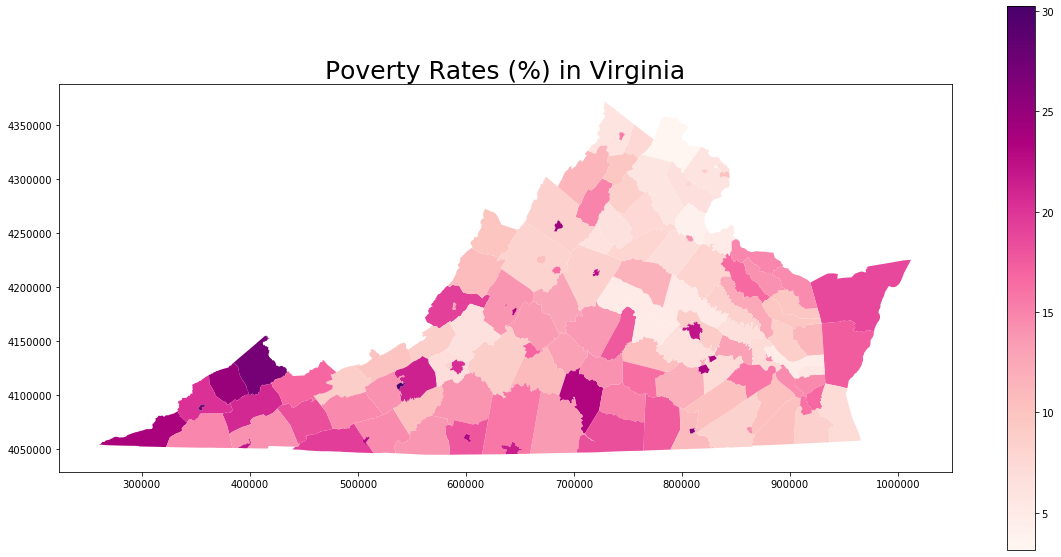

In [14]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
va_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Virginia', fontdict = {'fontsize': '25', 'fontweight' : '3'})